In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
from pathlib import Path
import swifter # used even though marked as unused, do not delete 
from utils.fltrace_classes import *
from utils.constants import *
from utils.prepro import *
from plotters import plotter
import matplotlib.pyplot as plt
from itertools import chain
from utils.graphs import get_connection_graph,get_sink_source_stats
from networkx import write_gml
from concurrent.futures import ProcessPoolExecutor as Pool
from functools import partial
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
PARENT_DIR = "/home/garvalov/mlp2/data/data/parsec_raw_out/"
OBJDUMP_FOLDER_PATH = "../data/objdumps/"

PARENT_OUTS = "outs/zoomed_in/"
NM = "nm/"

GRAPH_OUT = PARENT_OUTS+"graphs/"
TIMELINE_OUT = PARENT_OUTS+"timelines/"

GRAPH_NM = GRAPH_OUT+NM
TIMELINE_NM = TIMELINE_OUT+NM
FILE_SAVETYPE_EXTENSION = ".pdf"


In [25]:

def process_grandchild(bn,grandchild):
    #graph_out_path = Path(GRAPH_OUT)
    tl_out_path = Path(TIMELINE_OUT)
    tl_out_path.mkdir(parents=True,exist_ok=True)
    #nm_graph_out_path = Path(GRAPH_NM)
    #nm_tl_out_path = Path(TIMELINE_NM)
    #graph_out_path.mkdir(parents=True,exist_ok=True)
    #nm_graph_out_path.mkdir(parents=True,exist_ok=True)
    #nm_tl_out_path.mkdir(parents=True,exist_ok=True)

    print(f"Starting processing of {bn}'s {grandchild}")
    check_correct_dir_str(grandchild)
    grand_child_errorstr_prefix = f"Grandchild {grandchild.absolute().as_posix()}"
    dir_name = grandchild.name
    assert "_" in dir_name, (grand_child_errorstr_prefix + "does not contain '_' in its name")
    m,l = splitted_name = dir_name.split(sep='_')
    assert len(splitted_name) == 2, (grand_child_errorstr_prefix + "contains more than 1 '_' in its name")
    assert splitted_name[0].isnumeric() and splitted_name[1].isnumeric(), ("The M/L values of "+ grand_child_errorstr_prefix + "are not numbers")
    
    pids_to_procmaps_path = {}
    
    for trace_output in sorted(grandchild.iterdir(),reverse=True):
        trace_output: Path = trace_output
        assert trace_output.is_file()
        fname = trace_output.stem
        assert len(fname) > 0
        if fname[0] == ".":
            # Ignore hidden files
            continue
        assert fname.startswith(FLTRACE_OUTPUT_PREFIX), f"{trace_output.absolute().as_posix()} is not correctly prefixed"
        assert trace_output.suffix == FLTRACE_OUTPUT_SUFFIX, f"{trace_output.absolute().as_posix()} is not correctly suffixed"
        splitted_fname = fname.split("-")
        pid = int(splitted_fname[-2 if "faults" in fname else -1])
        filetype = splitted_fname[2]
        if filetype == "stats":
            continue
        elif filetype == "procmaps":
            pids_to_procmaps_path[pid] = trace_output
        elif filetype == "faults":
            assert pid in pids_to_procmaps_path.keys(), f"Received faults before procmaps here {trace_output.as_posix()}: are procmaps missing?"
            procmap_path = pids_to_procmaps_path[pid]
            runid = RunIdentifier(bn,int(m),int(l),pid)
            pct = round(int(100*runid.l/runid.m) / 25) * 25
            df = pd.read_csv(trace_output.as_posix())
            print(f"Loaded data for {runid}. Starting preprocessing.")
            df,epci = single_preprocess(runid,df, procmap_path,use_ints=True)
            print(f"Finished preprocessing data for {runid}%.")
            
            fig = plt.figure(figsize=(12, 6), dpi=100)
            ax = fig.add_subplot(111)

            # Plot scatter points
            pastel_blue = '#A7C7E7'  # Light blue
            pastel_edge = '#6B94B5'  # Slightly darker blue for edges
            ax.scatter(df.index, df["addr"], 
                    color=pastel_blue,
                    alpha=0.8, 
                    s=30,
                    edgecolor=pastel_edge,
                    linewidth=0.5,
                    rasterized=True,
                    zorder=2)

            # Configure grid
            ax.grid(True, linestyle='--', alpha=0.7, color='#E6E6E6')

            # Format y-axis to show hex values
            def hex_formatter(x, p):
                return f"0x{int(x):x}"
            ax.yaxis.set_major_formatter(plt.FuncFormatter(hex_formatter))

            # Customize labels and title
            ax.set_xlabel("Time", fontsize=10, fontweight='medium')
            ax.set_ylabel("Memory Address", fontsize=10, fontweight='medium')
            ax.set_title(f"Page Fault Trace - {runid.program_name} {pct}%", 
                        fontsize=12, 
                        fontweight='bold',
                        pad=20)

            # Rotate x-axis labels
            ax.tick_params(axis='x', rotation=45)

            # Set background color
            ax.set_facecolor('#F8F8F8')
            fig.patch.set_facecolor('white')

            # Save figure
            fig.tight_layout()
            fig.savefig((tl_out_path/str(runid)).absolute().as_posix()+".pdf", 
                        bbox_inches='tight', 
                        dpi=300)
            plt.close(fig)

            return "ok"
        else:
            raise LookupError(f"While looking at {bn}, found the following file in one of the grandchildren which doesn't seem to be the output of fltrace: {trace_output.absolute().as_posix()}")

def process_path(args):
   benchmark_name, grandchild = args
   process_grandchild(benchmark_name, grandchild)

def check_correct_children(path_to_child: Path):
    check_correct_dir_str(path_to_child)
    benchmark_name = path_to_child.name
    if "canneal" not in benchmark_name:
        return
    with Pool(4) as pool:
        args = [(path_to_child.name, gc) for gc in path_to_child.iterdir()]
        pool.map(process_path, args)
    print(f"All checks pass for {benchmark_name}.")

In [26]:
TO_PROCESS_FACESIM = "/home/garvalov/mlp2/data/data/parsec_raw_out/facesim/500_125"
TO_PROCESS_CANNEAL = "/home/garvalov/mlp2/data/data/parsec_raw_out/canneal/200_100"
process_grandchild("facesim",Path(TO_PROCESS_FACESIM))
process_grandchild("canneal",Path(TO_PROCESS_CANNEAL))

Starting processing of facesim's /home/garvalov/mlp2/data/data/parsec_raw_out/facesim/500_125
Loaded data for facesim_500_125_62702. Starting preprocessing.


Translating iphex to int:   0%|          | 0/211357 [00:00<?, ?it/s]

Splitting and translating st:   0%|          | 0/211357 [00:00<?, ?it/s]

Inspect! facesim 125/500: # of weird ips is 6/211357
Splitting stacktraces (can take several minutes)


Finding all ip librairies..: 100%|██████████| 1349/1349 [00:00<00:00, 444890.40it/s]


Removing all ips before fltrace:   0%|          | 0/210527 [00:00<?, ?it/s]

Translating addrhex to int:   0%|          | 0/210527 [00:00<?, ?it/s]

Finished preprocessing data for facesim_500_125_62702%.
Starting processing of canneal's /home/garvalov/mlp2/data/data/parsec_raw_out/canneal/200_100
Loaded data for canneal_200_100_59559. Starting preprocessing.


Translating iphex to int:   0%|          | 0/296847 [00:00<?, ?it/s]

Splitting and translating st:   0%|          | 0/296847 [00:00<?, ?it/s]

Inspect! canneal 100/200: # of weird ips is 4/296847
Splitting stacktraces (can take several minutes)


Finding all ip librairies..: 100%|██████████| 477/477 [00:00<00:00, 295696.57it/s]


Removing all ips before fltrace:   0%|          | 0/294137 [00:00<?, ?it/s]

Translating addrhex to int:   0%|          | 0/294137 [00:00<?, ?it/s]

Finished preprocessing data for canneal_200_100_59559%.


'ok'

In [27]:
def process_grandchild(bn, grandchild):
    tl_out_path = Path(TIMELINE_OUT)
    tl_out_path.mkdir(parents=True, exist_ok=True)
    
    print(f"Starting processing of {bn}'s {grandchild}")
    check_correct_dir_str(grandchild)
    grand_child_errorstr_prefix = f"Grandchild {grandchild.absolute().as_posix()}"
    dir_name = grandchild.name
    assert "_" in dir_name, (grand_child_errorstr_prefix + "does not contain '_' in its name")
    m,l = splitted_name = dir_name.split(sep='_')
    assert len(splitted_name) == 2, (grand_child_errorstr_prefix + "contains more than 1 '_' in its name")
    assert splitted_name[0].isnumeric() and splitted_name[1].isnumeric(), ("The M/L values of "+ grand_child_errorstr_prefix + "are not numbers")
    
    pids_to_procmaps_path = {}
    
    for trace_output in sorted(grandchild.iterdir(), reverse=True):
        trace_output: Path = trace_output
        assert trace_output.is_file()
        fname = trace_output.stem
        assert len(fname) > 0
        if fname[0] == ".":
            # Ignore hidden files
            continue
        assert fname.startswith(FLTRACE_OUTPUT_PREFIX), f"{trace_output.absolute().as_posix()} is not correctly prefixed"
        assert trace_output.suffix == FLTRACE_OUTPUT_SUFFIX, f"{trace_output.absolute().as_posix()} is not correctly suffixed"
        splitted_fname = fname.split("-")
        pid = int(splitted_fname[-2 if "faults" in fname else -1])
        filetype = splitted_fname[2]
        if filetype == "stats":
            continue
        elif filetype == "procmaps":
            pids_to_procmaps_path[pid] = trace_output
        elif filetype == "faults":
            assert pid in pids_to_procmaps_path.keys(), f"Received faults before procmaps here {trace_output.as_posix()}: are procmaps missing?"
            procmap_path = pids_to_procmaps_path[pid]
            runid = RunIdentifier(bn, int(m), int(l), pid)
            pct = round(int(100*runid.l/runid.m) / 25) * 25
            df = pd.read_csv(trace_output.as_posix())
            print(f"Loaded data for {runid}. Starting preprocessing.")
            df, epci = single_preprocess(runid, df, procmap_path, use_ints=True)
            print(f"Finished preprocessing data for {runid}%.")
            
            # Set style for better-looking plots
            plt.style.use('seaborn-v0_8')
            
            # Create figure with a pleasant size
            fig = plt.figure(figsize=(12, 6), dpi=100)
            ax = fig.add_subplot(111)
            
            # Filter data for the zoom range
            mask = (df.index >= 100000) & (df.index <= 100300)
            zoom_df = df[mask]
            
            # Plot scatter with connecting lines using a pastel color
            pastel_blue = '#A7C7E7'  # Light blue
            pastel_edge = '#6B94B5'  # Slightly darker blue for edges
            
            # Plot the connecting lines first
            ax.plot(zoom_df.index, zoom_df["addr"], 
                   color=pastel_edge, 
                   linewidth=0.5, 
                   alpha=0.6,
                   zorder=1)
            
            # Then plot the scatter points on top
            ax.scatter(zoom_df.index, zoom_df["addr"], 
                      color=pastel_blue,
                      alpha=0.8, 
                      s=30,
                      edgecolor=pastel_edge,
                      linewidth=0.5,
                      zorder=2)
            
            # Configure grid
            ax.grid(True, linestyle='--', alpha=0.7, color='#E6E6E6')
            
            # Format y-axis to show hex values
            def hex_formatter(x, p):
                return f"0x{int(x):x}"
            ax.yaxis.set_major_formatter(plt.FuncFormatter(hex_formatter))
            
            # Customize labels and title
            ax.set_xlabel("Time", fontsize=10, fontweight='medium')
            ax.set_ylabel("Memory Address", fontsize=10, fontweight='medium')
            ax.set_title(f"Page Fault Trace - {runid.program_name} {pct}%\n(Zoomed View: 100000-100300)", 
                        fontsize=12, 
                        fontweight='bold',
                        pad=20)
            
            # Rotate x-axis labels for better readability
            ax.tick_params(axis='x', rotation=45)
            
            # Set background color
            ax.set_facecolor('#F8F8F8')
            fig.patch.set_facecolor('white')
            
            # Adjust layout and save
            fig.tight_layout()
            save_path = (tl_out_path/str(runid)).absolute().as_posix() + "_zoomed.pdf"
            fig.savefig(save_path, bbox_inches='tight', dpi=300)
            plt.close(fig)
            
            return "ok"
        else:
            raise LookupError(f"While looking at {bn}, found the following file in one of the grandchildren which doesn't seem to be the output of fltrace: {trace_output.absolute().as_posix()}")

In [28]:

process_grandchild("canneal",Path(TO_PROCESS_CANNEAL))

Starting processing of canneal's /home/garvalov/mlp2/data/data/parsec_raw_out/canneal/200_100
Loaded data for canneal_200_100_59559. Starting preprocessing.


Translating iphex to int:   0%|          | 0/296847 [00:00<?, ?it/s]

Splitting and translating st:   0%|          | 0/296847 [00:00<?, ?it/s]

Inspect! canneal 100/200: # of weird ips is 4/296847
Splitting stacktraces (can take several minutes)


Finding all ip librairies..: 100%|██████████| 477/477 [00:00<00:00, 292711.49it/s]


Removing all ips before fltrace:   0%|          | 0/294137 [00:00<?, ?it/s]

Translating addrhex to int:   0%|          | 0/294137 [00:00<?, ?it/s]

Finished preprocessing data for canneal_200_100_59559%.


'ok'

In [20]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [5]:
Path(TIMELINE_OUT).mkdir(parents=True,exist_ok=True)
with Pool(5) as pool:
        paths = list(Path(PARENT_DIR).iterdir())
        pool.map(check_correct_children, paths)

Starting processing of canneal's /home/garvalov/mlp2/data/data/parsec_raw_out/canneal/200_100Starting processing of canneal's /home/garvalov/mlp2/data/data/parsec_raw_out/canneal/200_200Starting processing of canneal's /home/garvalov/mlp2/data/data/parsec_raw_out/canneal/200_150Starting processing of canneal's /home/garvalov/mlp2/data/data/parsec_raw_out/canneal/200_50



Loaded data for canneal_200_150_59957. Starting preprocessing.
Loaded data for canneal_200_200_60344. Starting preprocessing.


Translating iphex to int:   0%|          | 0/33717 [00:00<?, ?it/s]

Translating iphex to int:   0%|          | 0/33717 [00:00<?, ?it/s]

Splitting and translating st:   0%|          | 0/33717 [00:00<?, ?it/s]

Splitting and translating st:   0%|          | 0/33717 [00:00<?, ?it/s]

Inspect! canneal 150/200: # of weird ips is 1/33717
Inspect! canneal 200/200: # of weird ips is 1/33717
Splitting stacktraces (can take several minutes)
Splitting stacktraces (can take several minutes)


Finding all ip librairies..: 100%|██████████| 190/190 [00:00<00:00, 215849.88it/s]


Removing all ips before fltrace:   0%|          | 0/33201 [00:00<?, ?it/s]

Removing all ips before fltrace:   0%|          | 0/33201 [00:00<?, ?it/s]

Loaded data for canneal_200_100_59559. Starting preprocessing.


Translating iphex to int:   0%|          | 0/296847 [00:00<?, ?it/s]

Translating addrhex to int:   0%|          | 0/33201 [00:00<?, ?it/s]

Translating addrhex to int:   0%|          | 0/33201 [00:00<?, ?it/s]

Finished preprocessing data for canneal_200_200_60344%.
Finished preprocessing data for canneal_200_150_59957%.


Splitting and translating st:   0%|          | 0/296847 [00:00<?, ?it/s]

Inspect! canneal 100/200: # of weird ips is 4/296847
Splitting stacktraces (can take several minutes)


Finding all ip librairies..: 100%|██████████| 477/477 [00:00<00:00, 250367.04it/s]


Removing all ips before fltrace:   0%|          | 0/294137 [00:00<?, ?it/s]

Translating addrhex to int:   0%|          | 0/294137 [00:00<?, ?it/s]

Finished preprocessing data for canneal_200_100_59559%.
Loaded data for canneal_200_50_58940. Starting preprocessing.


Translating iphex to int:   0%|          | 0/11118235 [00:00<?, ?it/s]

Splitting and translating st:   0%|          | 0/11118235 [00:00<?, ?it/s]

Inspect! canneal 50/200: # of weird ips is 311/11118235
Splitting stacktraces (can take several minutes)


Finding all ip librairies..: 100%|██████████| 608/608 [00:00<00:00, 215930.30it/s]


Removing all ips before fltrace:   0%|          | 0/11038259 [00:00<?, ?it/s]

Translating addrhex to int:   0%|          | 0/11038259 [00:00<?, ?it/s]

Finished preprocessing data for canneal_200_50_58940%.
All checks pass for canneal.


___

/tmp/ipykernel_1534905/816322983.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='benchmark', y='Percentage of Unknown PCs', data=df, palette='husl')


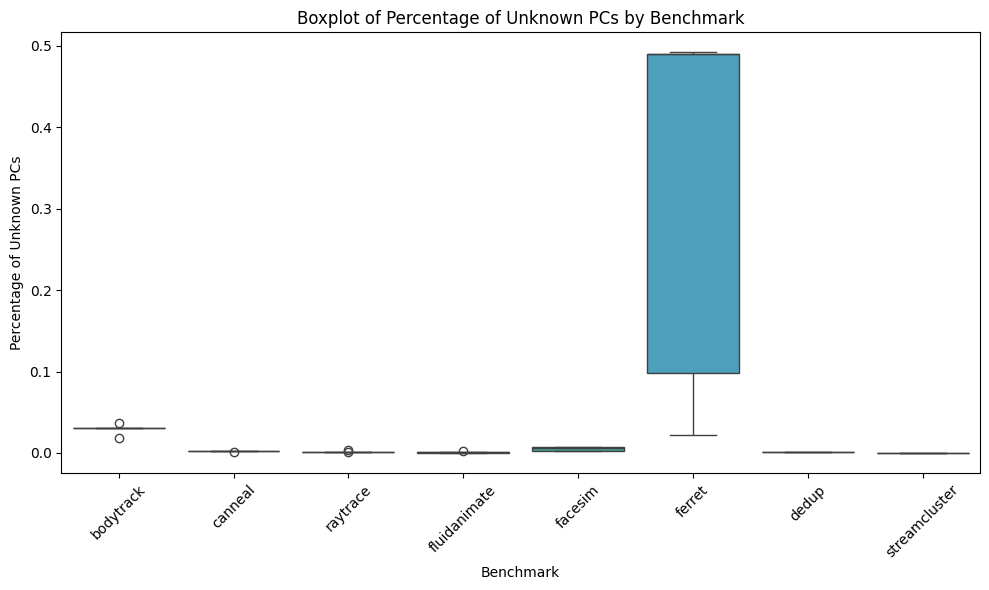


Average ratios:
benchmark
bodytrack        0.029234
canneal          0.002519
dedup            0.001805
facesim          0.004963
ferret           0.318641
fluidanimate     0.001226
raytrace         0.001971
streamcluster    0.000000
Name: Percentage of Unknown PCs, dtype: float64


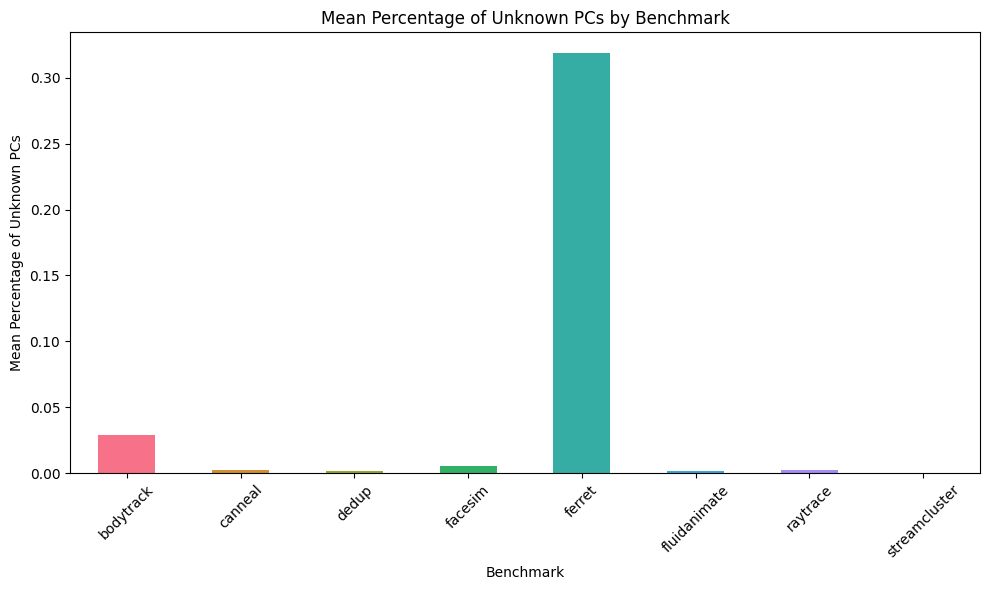

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract data
lines = """Inspect! bodytrack 30/30: # of weird ips is 1/3314
Inspect! bodytrack 6/30: # of weird ips is 2/10934
Inspect! canneal 200/200: # of weird ips is 1/33717
Inspect! bodytrack 7/30: # of weird ips is 4/10709
Inspect! raytrace 100/400: # of weird ips is 1/60243
Inspect! raytrace 84/400: # of weird ips is 2/64070
Inspect! fluidanimate 500/500: # of weird ips is 1/78456
Inspect! fluidanimate 250/500: # of weird ips is 2/78512
Inspect! bodytrack 22/30: # of weird ips is 1/3314
Inspect! facesim 500/500: # of weird ips is 6/86781
Inspect! facesim 250/500: # of weird ips is 6/104118
Inspect! bodytrack 15/30: # of weird ips is 1/3314
Inspect! ferret 75/150: # of weird ips is 301/61174
Inspect! canneal 150/200: # of weird ips is 1/33717
Inspect! canneal 100/200: # of weird ips is 4/296847
Inspect! raytrace 200/400: # of weird ips is 1/59111
Inspect! raytrace 400/400: # of weird ips is 1/59114
Inspect! fluidanimate 375/500: # of weird ips is 1/78457
Inspect! facesim 375/500: # of weird ips is 6/87252
Inspect! raytrace 300/400: # of weird ips is 1/59111
Inspect! fluidanimate 100/500: # of weird ips is 2/410611
Inspect! ferret 37/150: # of weird ips is 304/310137
Inspect! facesim 100/500: # of weird ips is 6/247780
Inspect! dedup 200/1000: # of weird ips is 1/56254
Inspect! dedup 250/1000: # of weird ips is 1/56353
Inspect! fluidanimate 125/500: # of weird ips is 2/366391
Inspect! facesim 125/500: # of weird ips is 6/211357
Inspect! dedup 750/1000: # of weird ips is 1/54855
Inspect! dedup 500/1000: # of weird ips is 1/54743
Inspect! ferret 30/150: # of weird ips is 303/1359877
Inspect! dedup 1000/1000: # of weird ips is 1/54848
Inspect! streamcluster 25/50: # of weird ips is 0/2289
Inspect! streamcluster 12/50: # of weird ips is 0/2291
Inspect! streamcluster 10/50: # of weird ips is 0/2289
Inspect! streamcluster 37/50: # of weird ips is 0/2291
Inspect! streamcluster 50/50: # of weird ips is 0/2293
Inspect! ferret 150/150: # of weird ips is 300/61159
Inspect! ferret 112/150: # of weird ips is 300/61182
Inspect! canneal 50/200: # of weird ips is 311/11118235
""".strip().split('\n')

# Parse into dataframe
data = []
for line in lines:
    parts = line.split()
    benchmark = parts[1]
    weird, total = map(int, parts[-1].split('/'))
    ratio = 100*weird/total
    data.append({'benchmark': benchmark, 'Percentage of Unknown PCs': ratio})

df = pd.DataFrame(data)

# Create plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='benchmark', y='Percentage of Unknown PCs', data=df, palette='husl')
plt.title('Boxplot of Percentage of Unknown PCs by Benchmark')
plt.xlabel('Benchmark')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('unknown_pcs_boxplot.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Print average ratios
print("\nAverage ratios:")
print(df.groupby('benchmark')['Percentage of Unknown PCs'].mean())

plt.figure(figsize=(10, 6))
means = df.groupby('benchmark')['Percentage of Unknown PCs'].mean()
means.plot(kind='bar', color=sns.color_palette('husl', n_colors=len(means)))
plt.title('Mean Percentage of Unknown PCs by Benchmark')
plt.xlabel('Benchmark')
plt.ylabel('Mean Percentage of Unknown PCs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('unknown_pcs_means.pdf', dpi=300, bbox_inches='tight')
plt.show()